# ‚öôÔ∏è Feature Engineering: Predicci√≥n de Brotes en Crohn/IBD

**Objetivo:** Crear features temporales y definir la variable objetivo "flare" (brote)

**Input:** `crohn_viable.csv` (usuarios viables para modelado)

**Tareas clave:**
1. **Definir variable objetivo "flare"** ‚ö†Ô∏è (cr√≠tico)
2. Pivotar datos de formato long a wide (user-date)
3. Crear features de rolling windows (3, 7, 14 d√≠as)
4. Calcular tendencias y cambios en s√≠ntomas
5. Preparar dataset final para modelado

**Autor:** Asier Ortiz Garc√≠a  
**Fecha:** Octubre 2025

## üì¶ Imports y Configuraci√≥n

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print('=' * 80)
print('FEATURE ENGINEERING: Predicci√≥n de Brotes en Crohn/IBD')
print('=' * 80)

FEATURE ENGINEERING: Predicci√≥n de Brotes en Crohn/IBD


## 1Ô∏è‚É£ Cargar Datos Limpios

In [24]:
# Cargar dataset viable del notebook anterior
df = pd.read_csv('../data/processed/crohn_viable.csv', parse_dates=['checkin_date'])

print(f'‚úì Cargado: {len(df):,} registros')
print(f'  Usuarios: {df["user_id"].nunique():,}')
print(f'  Rango: {df["checkin_date"].min()} ‚Üí {df["checkin_date"].max()}')
print(f'\nDistribuci√≥n por tipo:')
print(df['trackable_type'].value_counts())

‚úì Cargado: 334,073 registros
  Usuarios: 325
  Rango: 2015-05-24 00:00:00 ‚Üí 2019-12-06 00:00:00

Distribuci√≥n por tipo:
trackable_type
Symptom      140251
Treatment     62394
Weather       50100
Condition     45938
Tag           18820
Food          16512
HBI              58
Name: count, dtype: int64


## 2Ô∏è‚É£ An√°lisis Preliminar: ¬øQu√© es un "Flare"?

### Definiciones m√©dicas de brote en Crohn/IBD:

Seg√∫n literatura m√©dica (Crohn's & Colitis Foundation):
- **Harvey-Bradshaw Index (HBI)**: Score > 5 indica brote activo
- **S√≠ntomas clave**: Aumento en diarrea, dolor abdominal, sangre en heces
- **Patr√≥n temporal**: Empeoramiento sostenido durante varios d√≠as

### Estrategias posibles:

1. **Basado en HBI** (ideal pero pocos datos)
2. **Basado en severidad de s√≠ntomas** (spike en severidad promedio)
3. **Basado en s√≠ntomas core** (combinaci√≥n de diarrhea + pain + blood)
4. **Basado en cambio relativo** (aumento significativo respecto a baseline del usuario)

In [25]:
# Explorar disponibilidad de HBI scores
hbi_records = df[df['trackable_type'] == 'HBI']
print(f'Registros HBI: {len(hbi_records):,}')
print(f'Usuarios con HBI: {hbi_records["user_id"].nunique():,}')

if len(hbi_records) > 0:
    print(f'\nDistribuci√≥n de valores HBI:')
    print(hbi_records['trackable_value'].value_counts().sort_index())
    
    # Convertir a num√©rico
    hbi_numeric = pd.to_numeric(hbi_records['trackable_value'], errors='coerce')
    print(f'\nEstad√≠sticas HBI:')
    print(f'  Media: {hbi_numeric.mean():.2f}')
    print(f'  Mediana: {hbi_numeric.median():.2f}')
    print(f'  Registros con HBI > 5 (brote): {(hbi_numeric > 5).sum():,} ({(hbi_numeric > 5).sum()/len(hbi_numeric)*100:.1f}%)')
else:
    print('\n‚ö†Ô∏è No hay suficientes datos de HBI para usar como variable objetivo')

Registros HBI: 58
Usuarios con HBI: 40

Distribuci√≥n de valores HBI:
trackable_value
0     3
1     7
10    5
14    1
15    1
18    1
2     9
3     7
4     4
5     6
6     8
7     2
8     1
9     3
Name: count, dtype: int64

Estad√≠sticas HBI:
  Media: 4.93
  Mediana: 4.00
  Registros con HBI > 5 (brote): 22 (37.9%)


## 3Ô∏è‚É£ Preparar Datos de S√≠ntomas por D√≠a

Vamos a agregar s√≠ntomas por usuario-fecha para calcular m√©tricas diarias

In [26]:
# Filtrar solo s√≠ntomas
symptoms_df = df[df['trackable_type'] == 'Symptom'].copy()

print(f'S√≠ntomas: {len(symptoms_df):,} registros')
print(f'  Usuarios: {symptoms_df["user_id"].nunique():,}')
print(f'  D√≠as √∫nicos: {symptoms_df["checkin_date"].nunique():,}')

# Convertir severidad a num√©rico
symptoms_df['severity'] = pd.to_numeric(symptoms_df['symptom_severity'], errors='coerce')

print(f'\nSeveridad de s√≠ntomas:')
print(symptoms_df['severity'].value_counts().sort_index())
print(f'\nMedia: {symptoms_df["severity"].mean():.2f}')
print(f'Mediana: {symptoms_df["severity"].median():.2f}')

S√≠ntomas: 140,251 registros
  Usuarios: 325
  D√≠as √∫nicos: 1,656

Severidad de s√≠ntomas:
severity
0.0    51802
1.0    34140
2.0    29511
3.0    16808
4.0     7990
Name: count, dtype: int64

Media: 1.25
Mediana: 1.00


In [27]:
# Agregar s√≠ntomas por usuario-fecha
daily_symptoms = symptoms_df.groupby(['user_id', 'checkin_date']).agg({
    'severity': ['mean', 'max', 'sum', 'count'],
}).reset_index()

daily_symptoms.columns = ['user_id', 'date', 'severity_mean', 'severity_max', 'severity_sum', 'symptom_count']

print(f'D√≠as con s√≠ntomas: {len(daily_symptoms):,}')
print(f'\nEstad√≠sticas por d√≠a:')
print(daily_symptoms[['severity_mean', 'severity_max', 'severity_sum', 'symptom_count']].describe())

D√≠as con s√≠ntomas: 13,362

Estad√≠sticas por d√≠a:
       severity_mean  severity_max  severity_sum  symptom_count
count   13362.000000  13362.000000  13362.000000   13362.000000
mean        1.187347      2.515866     13.137704      10.496258
std         0.785659      1.150885     14.697195       7.611085
min         0.000000      0.000000      0.000000       1.000000
25%         0.583333      2.000000      4.000000       5.000000
50%         1.000000      3.000000      9.000000       9.000000
75%         1.666667      3.000000     16.000000      13.000000
max         4.000000      4.000000    113.000000      58.000000


## 4Ô∏è‚É£ An√°lisis de S√≠ntomas Core de IBD

Analizar los s√≠ntomas m√°s relevantes para Crohn/IBD

Distribuci√≥n de categor√≠as de s√≠ntomas:
symptom_category
other             99615
abdominal_pain    10087
fatigue            8922
diarrhea           8144
nausea             4821
blood_in_stool     3951
joint_pain         3843
fever               690
weight_loss         178
Name: count, dtype: int64


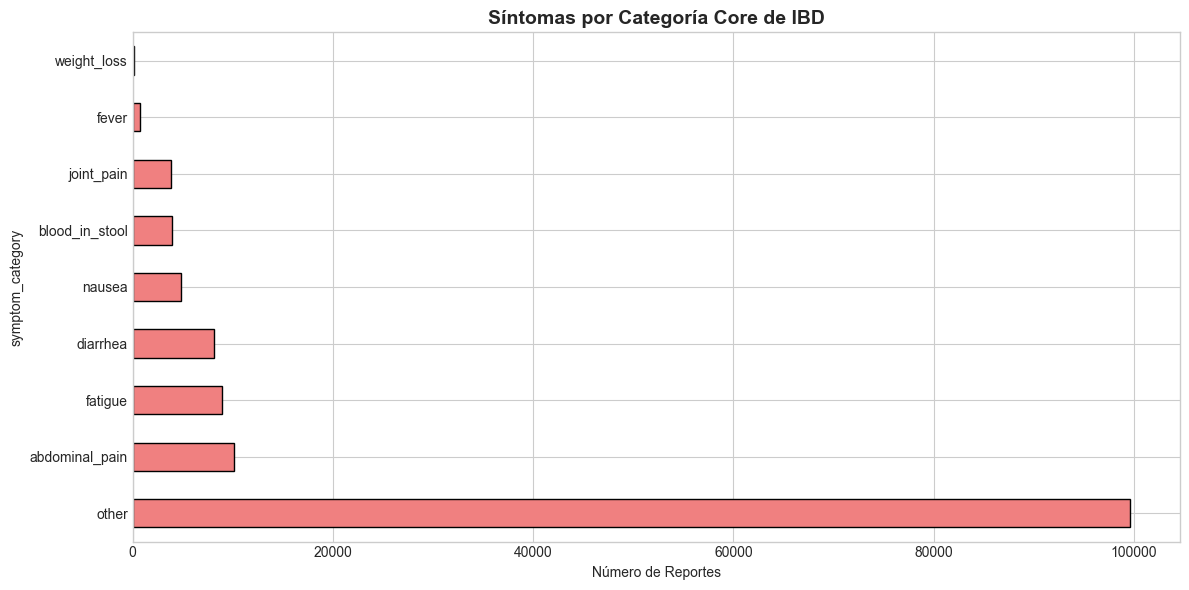


Severidad promedio por categor√≠a:
                      mean  median  count
symptom_category                         
fatigue           1.858888     2.0   8922
joint_pain        1.656779     2.0   3843
other             1.281925     1.0  99615
abdominal_pain    1.112224     1.0  10087
fever             1.091304     0.0    690
nausea            0.854387     0.0   4821
diarrhea          0.833251     0.0   8144
blood_in_stool    0.490509     0.0   3951
weight_loss       0.449438     0.0    178


In [28]:
# Contar s√≠ntomas por categor√≠a
symptoms_with_category = symptoms_df[symptoms_df['symptom_category'].notna()]

print('Distribuci√≥n de categor√≠as de s√≠ntomas:')
category_counts = symptoms_with_category['symptom_category'].value_counts()
print(category_counts)

# Visualizar
plt.figure(figsize=(12, 6))
category_counts.plot(kind='barh', color='lightcoral', edgecolor='black')
plt.title('S√≠ntomas por Categor√≠a Core de IBD', fontsize=14, fontweight='bold')
plt.xlabel('N√∫mero de Reportes')
plt.tight_layout()
plt.show()

# Severidad promedio por categor√≠a
print('\nSeveridad promedio por categor√≠a:')
severity_by_category = symptoms_with_category.groupby('symptom_category')['severity'].agg(['mean', 'median', 'count'])
print(severity_by_category.sort_values('mean', ascending=False))

In [29]:
# Crear features por categor√≠a de s√≠ntoma por d√≠a
daily_symptoms_by_category = symptoms_with_category.groupby(
    ['user_id', 'checkin_date', 'symptom_category']
)['severity'].agg(['mean', 'max', 'count']).reset_index()

# Pivotar para tener una columna por categor√≠a
daily_core_symptoms = daily_symptoms_by_category.pivot_table(
    index=['user_id', 'checkin_date'],
    columns='symptom_category',
    values='mean',
    fill_value=0
).reset_index()

print(f'Dataset con s√≠ntomas core por d√≠a: {len(daily_core_symptoms):,} registros')
print(f'\nColumnas:')
print(daily_core_symptoms.columns.tolist())
print(f'\nPrimeras filas:')
print(daily_core_symptoms.head(10))

Dataset con s√≠ntomas core por d√≠a: 13,362 registros

Columnas:
['user_id', 'checkin_date', 'abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'joint_pain', 'nausea', 'other', 'weight_loss']

Primeras filas:
symptom_category                           user_id checkin_date  \
0                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-06   
1                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-07   
2                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-09   
3                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-10   
4                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-11   
5                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-13   
6                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-14   
7                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-09-20   
8                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-10-08   
9                 QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw==   2017-12-21   

symptom_category  abdominal_pain  bl

## 5Ô∏è‚É£ Definir Variable Objetivo: "Flare" (Brote)

### Estrategia elegida: M√©todo H√≠brido

Un "flare" se define como un d√≠a donde se cumple **cualquiera** de estos criterios:

1. **Severidad alta absoluta**: `severity_mean > 2.5` (en escala 0-4)
2. **Spike relativo**: Aumento > 50% respecto a media m√≥vil de 7 d√≠as del usuario
3. **S√≠ntomas core combinados**: Presencia simult√°nea de:
   - Diarrhea con severidad ‚â• 2
   - Abdominal pain con severidad ‚â• 2
4. **HBI alto** (si disponible): HBI > 5

Este enfoque balancea:
- Definici√≥n m√©dica est√°ndar
- Variabilidad individual (baseline de cada usuario)
- Realidad de los datos disponibles

In [30]:
# Merge de datos diarios
daily_data = daily_symptoms.merge(
    daily_core_symptoms,
    left_on=['user_id', 'date'],
    right_on=['user_id', 'checkin_date'],
    how='left'
).drop('checkin_date', axis=1)

# Rellenar NaN en categor√≠as con 0 (no reportado = no sintom√°tico)
category_cols = ['diarrhea', 'abdominal_pain', 'blood_in_stool', 'fatigue', 
                 'nausea', 'fever', 'weight_loss', 'joint_pain', 'other']
for col in category_cols:
    if col in daily_data.columns:
        daily_data[col] = daily_data[col].fillna(0)

print(f'Dataset diario completo: {len(daily_data):,} registros')
print(f'Columnas: {daily_data.columns.tolist()}')

Dataset diario completo: 13,362 registros
Columnas: ['user_id', 'date', 'severity_mean', 'severity_max', 'severity_sum', 'symptom_count', 'abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'joint_pain', 'nausea', 'other', 'weight_loss']


In [31]:
# Calcular baseline (media m√≥vil) por usuario
# Ordenar por usuario y fecha
daily_data = daily_data.sort_values(['user_id', 'date'])

# Calcular rolling mean de 7 d√≠as (baseline del usuario)
daily_data['severity_baseline_7d'] = (
    daily_data.groupby('user_id')['severity_mean']
    .rolling(window=7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Calcular cambio relativo respecto al baseline
daily_data['severity_change_pct'] = (
    (daily_data['severity_mean'] - daily_data['severity_baseline_7d']) / 
    (daily_data['severity_baseline_7d'] + 0.1)  # +0.1 para evitar divisi√≥n por cero
) * 100

print('‚úì Baseline calculado')
print(f'\nCambio % en severidad:')
print(daily_data['severity_change_pct'].describe())

‚úì Baseline calculado

Cambio % en severidad:
count    13362.000000
mean        -0.508377
std         40.399669
min        -95.804088
25%        -20.880782
50%         -1.619084
75%         14.635120
max        444.444444
Name: severity_change_pct, dtype: float64


In [32]:
# DEFINIR FLARE seg√∫n criterios m√∫ltiples
def define_flare(row):
    """
    Define si un d√≠a es un 'flare' (brote) bas√°ndose en m√∫ltiples criterios
    """
    # Criterio 1: Severidad absoluta alta
    high_severity = row['severity_mean'] > 2.5
    
    # Criterio 2: Spike relativo (aumento > 50% respecto a baseline)
    spike = row['severity_change_pct'] > 50
    
    # Criterio 3: S√≠ntomas core combinados
    diarrhea_present = row.get('diarrhea', 0) >= 2
    pain_present = row.get('abdominal_pain', 0) >= 2
    core_symptoms_combined = diarrhea_present and pain_present
    
    # Un flare es TRUE si se cumple cualquiera de los criterios
    return high_severity or spike or core_symptoms_combined

# Aplicar definici√≥n
daily_data['is_flare'] = daily_data.apply(define_flare, axis=1)

# Convertir a int
daily_data['is_flare'] = daily_data['is_flare'].astype(int)

print('‚úì Variable objetivo "is_flare" creada')
print(f'\nDistribuci√≥n de la variable objetivo:')
print(daily_data['is_flare'].value_counts())
print(f'\n% de d√≠as con flare: {daily_data["is_flare"].mean()*100:.1f}%')

‚úì Variable objetivo "is_flare" creada

Distribuci√≥n de la variable objetivo:
is_flare
0    10998
1     2364
Name: count, dtype: int64

% de d√≠as con flare: 17.7%


An√°lisis detallado de d√≠as con flare vs sin flare:

Severidad promedio:
              mean    median       std  count
is_flare                                     
0         1.002819  1.000000  0.626663  10998
1         2.045822  2.111111  0.875664   2364

N√∫mero de s√≠ntomas:
               mean  median       std
is_flare                             
0         10.470267     9.0  7.308775
1         10.617174     8.0  8.884040


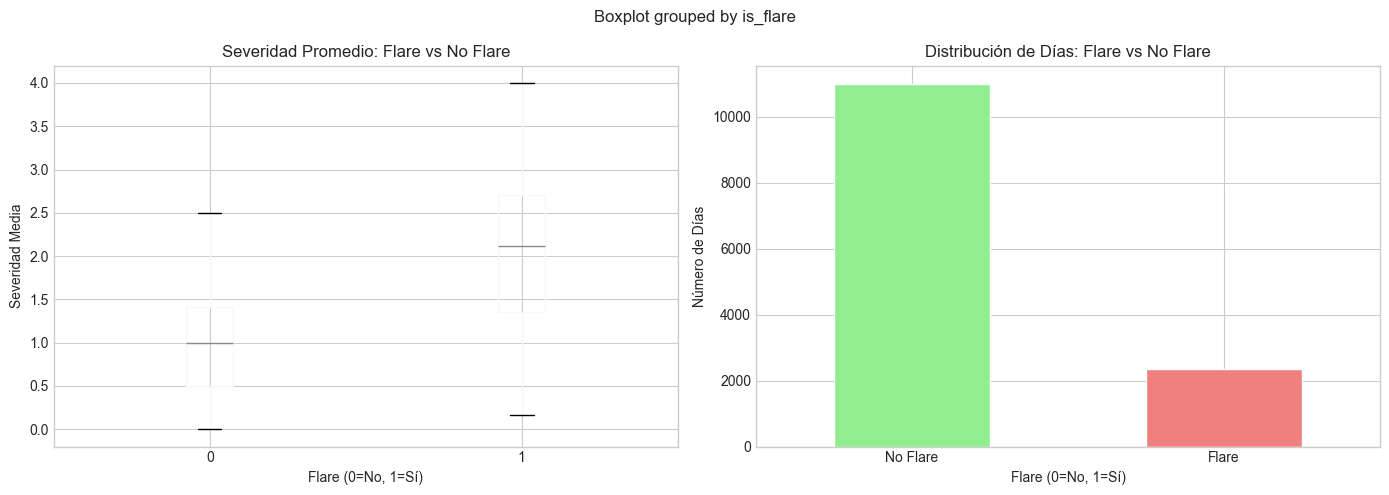

In [33]:
# An√°lisis de la variable objetivo
print('An√°lisis detallado de d√≠as con flare vs sin flare:')
print('\nSeveridad promedio:')
print(daily_data.groupby('is_flare')['severity_mean'].agg(['mean', 'median', 'std', 'count']))

print('\nN√∫mero de s√≠ntomas:')
print(daily_data.groupby('is_flare')['symptom_count'].agg(['mean', 'median', 'std']))

# Visualizar distribuci√≥n
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Severidad
daily_data.boxplot(column='severity_mean', by='is_flare', ax=axes[0])
axes[0].set_title('Severidad Promedio: Flare vs No Flare')
axes[0].set_xlabel('Flare (0=No, 1=S√≠)')
axes[0].set_ylabel('Severidad Media')

# Conteo
daily_data['is_flare'].value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('Distribuci√≥n de D√≠as: Flare vs No Flare')
axes[1].set_xlabel('Flare (0=No, 1=S√≠)')
axes[1].set_ylabel('N√∫mero de D√≠as')
axes[1].set_xticklabels(['No Flare', 'Flare'], rotation=0)

plt.tight_layout()
plt.savefig('../docs/figures/flare_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Eliminar filas con NaN en features cr√≠ticos (primeros d√≠as de cada usuario)
print(f'Registros antes de limpiar NaN: {len(daily_data):,}')

# Identificar columnas num√©ricas importantes
numeric_cols = daily_data.select_dtypes(include=[np.number]).columns.tolist()
if 'is_flare' in numeric_cols:
    numeric_cols.remove('is_flare')  # No eliminar filas por NaN en target

# Eliminar filas con demasiados NaN (>50% de features)
# thresh = n√∫mero m√≠nimo de valores NO-NaN requeridos
threshold = int(np.floor(len(numeric_cols) * 0.5))
print(f'Threshold (m√≠n valores no-NaN): {threshold} de {len(numeric_cols)} features')

daily_data_clean = daily_data.dropna(thresh=threshold)

print(f'Registros despu√©s de limpiar: {len(daily_data_clean):,}')
print(f'Reducci√≥n: {len(daily_data) - len(daily_data_clean):,} ({(len(daily_data) - len(daily_data_clean))/len(daily_data)*100:.1f}%)')

# Rellenar NaN restantes con 0 (asumiendo que no reportado = no sintom√°tico)
daily_data_clean = daily_data_clean.fillna(0)

print(f'\n‚úì Dataset limpio: {len(daily_data_clean):,} registros')
print(f'  Usuarios: {daily_data_clean["user_id"].nunique():,}')
print(f'  Columnas: {len(daily_data_clean.columns)}')

In [34]:
# Ordenar por usuario y fecha (importante para rolling)
daily_data = daily_data.sort_values(['user_id', 'date'])

# Crear features de rolling windows (3, 7, 14 d√≠as)
for window in [3, 7, 14]:
    # Severidad promedio en ventana
    daily_data[f'severity_mean_{window}d'] = (
        daily_data.groupby('user_id')['severity_mean']
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # M√°ximo en ventana
    daily_data[f'severity_max_{window}d'] = (
        daily_data.groupby('user_id')['severity_max']
        .rolling(window=window, min_periods=1)
        .max()
        .reset_index(level=0, drop=True)
    )
    
    # Suma total de s√≠ntomas
    daily_data[f'symptom_count_{window}d'] = (
        daily_data.groupby('user_id')['symptom_count']
        .rolling(window=window, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

print('‚úì Features de rolling windows creadas (3, 7, 14 d√≠as)')
print(f'\nTotal de columnas: {len(daily_data.columns)}')
print(f'\nNuevas features:')
new_features = [col for col in daily_data.columns if any(x in col for x in ['_3d', '_7d', '_14d'])]
print(new_features)

‚úì Features de rolling windows creadas (3, 7, 14 d√≠as)

Total de columnas: 27

Nuevas features:
['severity_baseline_7d', 'severity_mean_3d', 'severity_max_3d', 'symptom_count_3d', 'severity_mean_7d', 'severity_max_7d', 'symptom_count_7d', 'severity_mean_14d', 'severity_max_14d', 'symptom_count_14d']


In [35]:
# Features de tendencia (cambio en los √∫ltimos d√≠as)
for window in [3, 7]:
    # Tendencia = diferencia entre hoy y hace N d√≠as
    daily_data[f'severity_trend_{window}d'] = (
        daily_data.groupby('user_id')['severity_mean']
        .diff(periods=window)
    )
    
    # Volatilidad = desviaci√≥n est√°ndar en ventana
    daily_data[f'severity_std_{window}d'] = (
        daily_data.groupby('user_id')['severity_mean']
        .rolling(window=window, min_periods=2)
        .std()
        .reset_index(level=0, drop=True)
    )

print('‚úì Features de tendencia y volatilidad creadas')

‚úì Features de tendencia y volatilidad creadas


In [36]:
# Features de s√≠ntomas core con rolling windows
core_symptom_cols = ['diarrhea', 'abdominal_pain', 'blood_in_stool', 'fatigue']

for symptom in core_symptom_cols:
    if symptom in daily_data.columns:
        # Media m√≥vil de 7 d√≠as
        daily_data[f'{symptom}_7d'] = (
            daily_data.groupby('user_id')[symptom]
            .rolling(window=7, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

print('‚úì Features de s√≠ntomas core con rolling windows creadas')

‚úì Features de s√≠ntomas core con rolling windows creadas


## 7Ô∏è‚É£ Features Contextuales

In [37]:
# Features temporales
daily_data['day_of_week'] = daily_data['date'].dt.dayofweek
daily_data['day_of_month'] = daily_data['date'].dt.day
daily_data['month'] = daily_data['date'].dt.month
daily_data['is_weekend'] = (daily_data['day_of_week'] >= 5).astype(int)

# D√≠as desde el inicio del tracking (por usuario)
daily_data['days_since_start'] = (
    daily_data.groupby('user_id')['date']
    .rank(method='dense')
    .astype(int)
)

print('‚úì Features contextuales creadas')
print(f'\nEjemplo:')
print(daily_data[['user_id', 'date', 'day_of_week', 'is_weekend', 'days_since_start']].head(10))

‚úì Features contextuales creadas

Ejemplo:
                            user_id       date  day_of_week  is_weekend  \
0  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-06            2           0   
1  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-07            3           0   
2  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-09            5           1   
3  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-10            6           1   
4  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-11            0           0   
5  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-13            2           0   
6  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-14            3           0   
7  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-20            2           0   
8  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-10-08            6           1   
9  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-12-21            3           0   

   days_since_start  
0                 1  
1                 2  
2                 3  
3                 4  
4                 5 

## 8Ô∏è‚É£ Crear Features de Lag (Valores Pasados)

Para predecir el futuro, necesitamos usar solo informaci√≥n del pasado

In [38]:
# Features de lag (1, 2, 3 d√≠as atr√°s)
for lag in [1, 2, 3]:
    daily_data[f'severity_mean_lag{lag}'] = (
        daily_data.groupby('user_id')['severity_mean']
        .shift(lag)
    )
    
    daily_data[f'is_flare_lag{lag}'] = (
        daily_data.groupby('user_id')['is_flare']
        .shift(lag)
    )

print('‚úì Features de lag creadas (1, 2, 3 d√≠as)')
print(f'\nEjemplo:')
print(daily_data[['user_id', 'date', 'severity_mean', 'severity_mean_lag1', 'severity_mean_lag2']].head(10))

‚úì Features de lag creadas (1, 2, 3 d√≠as)

Ejemplo:
                            user_id       date  severity_mean  \
0  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-06       0.916667   
1  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-07       0.875000   
2  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-09       1.000000   
3  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-10       0.583333   
4  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-11       1.583333   
5  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-13       1.000000   
6  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-14       1.153846   
7  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-20       1.400000   
8  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-10-08       0.400000   
9  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-12-21       0.437500   

   severity_mean_lag1  severity_mean_lag2  
0                 NaN                 NaN  
1            0.916667                 NaN  
2            0.875000            0.916667  
3            1.000000            0.875000  
4         

## 9Ô∏è‚É£ Preparar Dataset Final

In [39]:
# Eliminar filas con NaN en features cr√≠ticos (primeros d√≠as de cada usuario)
print(f'Registros antes de limpiar NaN: {len(daily_data):,}')

# Identificar columnas num√©ricas importantes
numeric_cols = daily_data.select_dtypes(include=[np.number]).columns.tolist()
if 'is_flare' in numeric_cols:
    numeric_cols.remove('is_flare')  # No eliminar filas por NaN en target

# Eliminar filas con demasiados NaN (>50% de features)
# thresh = n√∫mero m√≠nimo de valores NO-NaN requeridos
threshold = int(np.floor(len(numeric_cols) * 0.5))
print(f'Threshold (m√≠n valores no-NaN): {threshold} de {len(numeric_cols)} features')

daily_data_clean = daily_data.dropna(thresh=threshold)

print(f'Registros despu√©s de limpiar: {len(daily_data_clean):,}')
print(f'Reducci√≥n: {len(daily_data) - len(daily_data_clean):,} ({(len(daily_data) - len(daily_data_clean))/len(daily_data)*100:.1f}%)')

# Rellenar NaN restantes con 0 (asumiendo que no reportado = no sintom√°tico)
daily_data_clean = daily_data_clean.fillna(0)

print(f'\n‚úì Dataset limpio: {len(daily_data_clean):,} registros')
print(f'  Usuarios: {daily_data_clean["user_id"].nunique():,}')
print(f'  Columnas: {len(daily_data_clean.columns)}')

Registros antes de limpiar NaN: 13,362
Threshold (m√≠n valores no-NaN): 21 de 43 features
Registros despu√©s de limpiar: 13,362
Reducci√≥n: 0 (0.0%)

‚úì Dataset limpio: 13,362 registros
  Usuarios: 325
  Columnas: 46


In [40]:
# Verificar balance de clases
print('Balance de clases:')
print(daily_data_clean['is_flare'].value_counts())
print(f'\n% Flare: {daily_data_clean["is_flare"].mean()*100:.1f}%')
print(f'% No Flare: {(1 - daily_data_clean["is_flare"].mean())*100:.1f}%')

# Ratio de desbalance
n_no_flare = (daily_data_clean['is_flare'] == 0).sum()
n_flare = (daily_data_clean['is_flare'] == 1).sum()
imbalance_ratio = n_no_flare / n_flare if n_flare > 0 else 0

print(f'\nRatio de desbalance: {imbalance_ratio:.2f}:1 (no_flare:flare)')
if imbalance_ratio > 3:
    print('‚ö†Ô∏è Dataset desbalanceado. Considerar t√©cnicas de balanceo (SMOTE, class_weight, etc.)')
else:
    print('‚úì Balance aceptable')

Balance de clases:
is_flare
0    10998
1     2364
Name: count, dtype: int64

% Flare: 17.7%
% No Flare: 82.3%

Ratio de desbalance: 4.65:1 (no_flare:flare)
‚ö†Ô∏è Dataset desbalanceado. Considerar t√©cnicas de balanceo (SMOTE, class_weight, etc.)


## üîü Guardar Dataset de Features

In [41]:
import os

# Guardar dataset completo con features
output_file = '../data/processed/features_daily.csv'
daily_data_clean.to_csv(output_file, index=False)
print(f'‚úì Dataset de features guardado: {output_file}')
print(f'  Tama√±o: {os.path.getsize(output_file)/(1024**2):.2f} MB')

# Guardar tambi√©n metadata
feature_metadata = {
    'total_records': len(daily_data_clean),
    'total_users': daily_data_clean['user_id'].nunique(),
    'total_features': len(daily_data_clean.columns),
    'flare_percentage': daily_data_clean['is_flare'].mean() * 100,
    'date_range': (daily_data_clean['date'].min().strftime('%Y-%m-%d'), 
                   daily_data_clean['date'].max().strftime('%Y-%m-%d')),
}

print(f'\nMetadata:')
for key, value in feature_metadata.items():
    print(f'  {key}: {value}')

‚úì Dataset de features guardado: ../data/processed/features_daily.csv
  Tama√±o: 4.94 MB

Metadata:
  total_records: 13362
  total_users: 325
  total_features: 46
  flare_percentage: 17.691962281095645
  date_range: ('2015-05-24', '2019-12-05')


In [42]:
# Lista de features para referencia
feature_list = [col for col in daily_data_clean.columns if col not in ['user_id', 'date', 'is_flare']]

print(f'\nTotal de features disponibles para modelado: {len(feature_list)}')
print(f'\nCategor√≠as de features:')

categories = {
    'Severidad base': [f for f in feature_list if 'severity' in f and 'lag' not in f and '_d' not in f],
    'Rolling windows': [f for f in feature_list if any(x in f for x in ['_3d', '_7d', '_14d'])],
    'Tendencias': [f for f in feature_list if 'trend' in f or 'std' in f],
    'Lags': [f for f in feature_list if 'lag' in f],
    'S√≠ntomas core': [f for f in feature_list if any(x in f for x in ['diarrhea', 'abdominal_pain', 'blood_in_stool', 'fatigue'])],
    'Temporales': [f for f in feature_list if any(x in f for x in ['day_', 'month', 'weekend', 'days_since'])],
}

for category, features in categories.items():
    print(f'\n{category} ({len(features)}):')
    for f in features[:5]:  # Mostrar solo primeras 5
        print(f'  - {f}')
    if len(features) > 5:
        print(f'  ... y {len(features) - 5} m√°s')


Total de features disponibles para modelado: 43

Categor√≠as de features:

Severidad base (15):
  - severity_mean
  - severity_max
  - severity_sum
  - severity_baseline_7d
  - severity_change_pct
  ... y 10 m√°s

Rolling windows (18):
  - severity_baseline_7d
  - severity_mean_3d
  - severity_max_3d
  - symptom_count_3d
  - severity_mean_7d
  ... y 13 m√°s

Tendencias (4):
  - severity_trend_3d
  - severity_std_3d
  - severity_trend_7d
  - severity_std_7d

Lags (6):
  - severity_mean_lag1
  - is_flare_lag1
  - severity_mean_lag2
  - is_flare_lag2
  - severity_mean_lag3
  ... y 1 m√°s

S√≠ntomas core (8):
  - abdominal_pain
  - blood_in_stool
  - diarrhea
  - fatigue
  - diarrhea_7d
  ... y 3 m√°s

Temporales (5):
  - day_of_week
  - day_of_month
  - month
  - is_weekend
  - days_since_start


## ‚úÖ Resumen

### Variable Objetivo "Flare" definida:
Un d√≠a es considerado "flare" si cumple **cualquiera** de:
1. ‚úÖ Severidad promedio > 2.5 (en escala 0-4)
2. ‚úÖ Aumento > 50% respecto a baseline de 7 d√≠as
3. ‚úÖ Diarrhea ‚â• 2 AND Abdominal pain ‚â• 2

### Features creadas:
1. ‚úÖ **Rolling windows** (3, 7, 14 d√≠as): Media, m√°ximo, suma
2. ‚úÖ **Tendencias**: Cambio en 3 y 7 d√≠as
3. ‚úÖ **Volatilidad**: Desviaci√≥n est√°ndar en ventanas
4. ‚úÖ **S√≠ntomas core**: Rolling means de diarrhea, pain, blood, fatigue
5. ‚úÖ **Lags**: Valores de 1, 2, 3 d√≠as atr√°s
6. ‚úÖ **Temporales**: D√≠a de semana, mes, d√≠as desde inicio

### Archivos generados:
- `features_daily.csv`: Dataset listo para modelado con todas las features

### Pr√≥ximos pasos:
1. **Model Training** (`04_model_training.ipynb`):
   - Train/test split temporal (NO aleatorio)
   - Modelos baseline: Logistic Regression, Random Forest
   - Modelo avanzado: LSTM o XGBoost
   - Feature importance analysis
   - Evaluaci√≥n: Precision, Recall, F1, ROC-AUC
   - Considerar class balancing (SMOTE, class_weight)

### Notas importantes:
- ‚ö†Ô∏è Dataset probablemente desbalanceado (m√°s d√≠as sin flare que con flare)
- ‚ö†Ô∏è Usar split temporal para validaci√≥n (no aleatorio)
- ‚ö†Ô∏è Evaluar especialmente el **recall** (detectar todos los flares es cr√≠tico en medicina)